# <center> Home Credit - Credit Risk Model Stability Data Challenge</center>

---

Link to the challenge: https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data



In [1]:

import math
import pandas as pd
import polars as pl
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from plotly.subplots import make_subplots
from scipy import stats


In [2]:
##### Functions used in notebook

def dataframe_summary(dataframe: pd.DataFrame,
                      max_length: int):
    
    pd.options.display.float_format = '{:,.4f}'.format

    ### Get list of column names
    col_names = dataframe.columns.to_list()

    ### Get unique count of each column
    col_length = [len(dataframe[val].unique()) for val in col_names]

    ### Append info for dataframe
    col_names.append("this_df")
    col_length.append(len(dataframe))

    ### Create new dataframe for summary
    summary_df = pd.DataFrame(list(zip(col_names, col_length)), columns=["column_name", "unique_count"])
    summary_df["uniqueness"] = summary_df["unique_count"]/len(dataframe) * 100

    ### Count nan values in each column
    nan_df = dataframe.isnull().sum(axis = 0).to_frame().reset_index().rename(columns={"index":"column_name", 0:"nan_count"})
    nan_df["nan_percent"] = nan_df["nan_count"]/len(dataframe)*100
    nan_df["percent_complete"] = 100 - nan_df["nan_percent"]

    ### Create new frame for data type in each column
    type_df = dataframe.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
    type_df["data_type"] = type_df["data_type"].astype(str)

    ### Create new dataframe with unique entries for each column

    col_name = []
    unique_val = []
    
    for val  in dataframe.columns.to_list():

        col_name.append(val)

        if len(dataframe[val].unique())<=max_length:
            unique_val.append(list(dataframe[val].unique()))

        else:
            unique_val.append(f">{max_length} entries")

    unique_df = pd.DataFrame(list(zip(col_name, unique_val)),
                             columns=["column_name", "unique_entries"])
    
    

    ### Merge summary_df with nan_df, type_df
    summary_df = summary_df.merge(nan_df, on="column_name", how="outer")
    summary_df = summary_df.merge(type_df, on="column_name", how="outer")
    summary_df = summary_df.merge(unique_df, on="column_name", how="outer")


    return summary_df.sort_values(["data_type", "nan_count"])


def describe_dataframe(dataframe: pd.DataFrame):
    
    pd.options.display.float_format = '{:,.3f}'.format
    
    return dataframe.select_dtypes([int, float]).describe()


def stats_tests(dataframe: pd.DataFrame):

    cols = [val for val in dataframe.columns if val!="target"]
    pvals = []
    tstats = []
    

    true_df = dataframe[dataframe["target"]==1]
    false_df = dataframe[dataframe["target"]==0]

    for col in cols:

        if is_numeric_dtype(dataframe[col]):
            result = stats.ttest_ind(true_df[col], false_df[col], nan_policy="omit")

            tstats.append(result.statistic)
            pvals.append(result.pvalue)

    result_df = pd.DataFrame(list(zip(cols, tstats, pvals)), columns=["col_name", "tstat", "pvalue"])

    return result_df




In [8]:
pd.set_option("styler.format.thousands", ",")


---
---
# <center> Data Exploration </center>
---



In [3]:
##### Load base data
base_df = pd.read_csv("./csv_files/train/train_base.csv")

##### Load static data
### * static and static_cb come from different sources
static_df_1 = pd.read_csv("./csv_files/train/train_static_0_0.csv")
static_df_2 = pd.read_csv("./csv_files/train/train_static_0_1.csv")
static_df = pd.concat([static_df_1, static_df_2])

static_cb = pd.read_csv("./csv_files/train/train_static_cb_0.csv")

##### Combine base, static, and static_cb
### * these can be combined since all three data have depth = 0. Hence they can be mapped back together
combined_df = base_df.merge(static_df, on=["case_id"])
combined_df = combined_df.merge(static_cb, on=["case_id"])
combined_df.head(5)


/var/folders/pq/7mcbx8c97t90g8y2_ns4gjkr0000gn/T/ipykernel_2804/648692701.py:6: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static_df_1 = pd.read_csv("./csv_files/train/train_static_0_0.csv")
/var/folders/pq/7mcbx8c97t90g8y2_ns4gjkr0000gn/T/ipykernel_2804/648692701.py:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static_df_2 = pd.read_csv("./csv_files/train/train_static_0_1.csv")
/var/folders/pq/7mcbx8c97t90g8y2_ns4gjkr0000gn/T/ipykernel_2804/648692701.py:10: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  static_cb = pd.read_csv("./csv_files/train/train_static_cb_0.csv")


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,357,2019-01-11,201901,1,0,NaN,NaN,7433.4,0.0,0.0,...,6.0,6301.4000,NaN,2019-01-25,NaN,NaN,NaN,NaN,NaN,NaN
1,381,2019-01-11,201901,1,0,0.0,NaN,2593.2,0.0,0.0,...,6.0,4019.6000,NaN,2019-01-25,NaN,NaN,NaN,NaN,NaN,NaN
2,388,2019-01-14,201901,1,0,NaN,NaN,5109.6,0.0,0.0,...,6.0,14548.0000,NaN,2019-01-28,NaN,NaN,NaN,NaN,3.0,5.0
3,405,2019-01-08,201901,1,0,NaN,NaN,10045.2,0.0,0.0,...,6.0,10498.2400,NaN,2019-01-21,NaN,NaN,NaN,NaN,2.0,0.0
4,409,2019-01-08,201901,1,0,NaN,NaN,1556.8,0.0,0.0,...,7.0,6344.8804,NaN,2019-01-21,NaN,NaN,NaN,NaN,0.0,4.0


In [4]:
combined_summary = dataframe_summary(combined_df, 15)

combined_summary

,column_name,unique_count,uniqueness,nan_count,nan_percent,percent_complete,data_type,unique_entries
68,isbidproduct_1095L,2,0.0001,0.0000,0.0000,100.0000,bool,"[False, True]"
7,annuity_780A,75044,5.0013,0.0000,0.0000,100.0000,float64,>15 entries
9,applicationcnt_361L,5,0.0003,0.0000,0.0000,100.0000,float64,"[0.0, 2.0, 1.0, 5.0, 3.0]"
10,applications30d_658L,25,0.0017,0.0000,0.0000,100.0000,float64,>15 entries
11,applicationscnt_1086L,125,0.0083,0.0000,0.0000,100.0000,float64,>15 entries
...,...,...,...,...,...,...,...,...
178,dateofbirth_342D,665,0.0443,"1,463,976.0000",97.5674,2.4326,object,>15 entries
69,isbidproductrequest_292L,3,0.0002,"1,488,228.0000",99.1837,0.8163,object,"[nan, False, True]"
150,payvacationpostpone_4187118D,597,0.0398,"1,491,149.0000",99.3784,0.6216,object,>15 entries
88,lastrepayingdate_696D,536,0.0357,"1,498,139.0000",99.8442,0.1558,object,>15 entries


In [12]:
fig_1 = px.bar(combined_summary, x="column_name", y="percent_complete", color="data_type",
               hover_data=["uniqueness", "data_type"])

fig_1.show()

In [13]:
##### Focus on data with at least 75% filled
complete_75 = combined_summary.loc[combined_summary["percent_complete"]>75, "column_name"].to_list()

##### Numerical data
numerics_75 = combined_df[complete_75]
numerics_75 = numerics_75.select_dtypes([int, float])
numerics_75

,annuity_780A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,...,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,commnoinclast6m_3546845L,maxdpdfrom6mto36m_3546853P,case_id,MONTH,WEEK_NUM,target
0,"7,433.4",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,357,201901,1,0
1,"2,593.2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,381,201901,1,0
2,"5,109.6",0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,388,201901,1,0
3,"10,045.2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,405,201901,1,0
4,"1,556.8",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,409,201901,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500471,"3,675.4001",0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,0.0,2703450,202010,91,0
1500472,"7,088.6",0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,2.0,2.0,2.0,0.0,0.0,2703451,202010,91,0
1500473,"7,788.8003",0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,4.0,2703452,202010,91,0
1500474,"1,195.4",0.0,0.0,36.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34.0,0.0,2.0,2703453,202010,91,0


In [14]:
class_count = numerics_75.groupby("target").count().reset_index()
class_count = class_count[["target", "annuity_780A"]].rename(columns={"annuity_780A":"count"})
class_count["percent"] = class_count["count"]/class_count["count"].sum()
class_count

fig_2 = px.bar(class_count, x="target", y="count", hover_data="percent")
fig_2.show()

In [15]:
numerics_75_corr = numerics_75.corr()

fig_3 = px.imshow(numerics_75_corr)

fig_3.update_layout(height=1000)
fig_3.show()

In [11]:
def high_corr_finder(corr_df, min_val):

    cols = corr_df.columns
    rows = corr_df.index

    abs_corr = abs(corr_df)

    

    for col in cols:
        temp = list(abs_corr[abs_corr[col]>min_val].index)
        

,annuity_780A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,...,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,commnoinclast6m_3546845L,maxdpdfrom6mto36m_3546853P,case_id,MONTH,WEEK_NUM,target
annuity_780A,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
applicationcnt_361L,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
applications30d_658L,NaN,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
applicationscnt_1086L,NaN,NaN,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
applicationscnt_464L,NaN,NaN,NaN,NaN,1.0000,0.9666,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
maxdpdfrom6mto36m_3546853P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5358,0.6219,0.6995,0.8573,NaN,1.0000,NaN,NaN,NaN,NaN
case_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,NaN
MONTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.8373,NaN
WEEK_NUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8373,1.0000,NaN


In [30]:
temp = abs(numerics_75_corr)

temp = list(temp[temp["annuity_780A"]>0.7].index)
temp.remove("annuity_780A")
temp

['credamount_770A', 'disbursedcredamount_1113A']

In [8]:
column_list = list(numerics_75.columns)
column_list = column_list[:40]

rows = 10
cols = 4

fig_1 = make_subplots(rows=rows, cols=cols, 
                    #   subplot_titles=column_list, 
                      horizontal_spacing=0.05)

counter = 0
for col_name in column_list:

    counter = counter + 1

    fig_1.add_trace(
        go.Histogram(x=combined_df[col_name], histnorm="probability", hovertemplate=f"{col_name}",
                     marker_color="blue"), 
        row=math.ceil(counter/cols), col=cols if counter%cols==0 else counter%cols
    )

    # print(counter)

fig_1.update_layout(showlegend=False,
                    height=100*rows)
fig_1.show()

----
----
# <center> Model </center>
----

In [31]:
import math, shap

import plotly.graph_objects as go
import tensorflow as tf


from keras import Model, Input
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Concatenate, Flatten
# from keras.layers.merge import concatenate
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras.utils import plot_model
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [32]:
def class_imbalance_treatment(df: pd.DataFrame):

    true_class = df[df["target"]==1]
    false_class = df[df["target"]==0]

    # true_to_false = len(true_class)/len(false_class)
    duplicate_factor = math.floor(len(false_class)/len(true_class))

    ##### create duplicated rows to increase the number of true class
    duplicated_true_class = true_class.loc[true_class.index.repeat(duplicate_factor)]

    ##### concatenate, reshuffle, and reindex dataframe
    new_df = pd.concat([false_class, duplicated_true_class], ignore_index=True)
    new_df = new_df.sample(frac=1)
    new_df = new_df.reset_index(drop=True)

    ##### random sampling of new_df to reduce size
    new_df_len = len(new_df)

    rng = np.random.default_rng(43)
    # random_sample = rng.integers(low=0, high=new_df_len, size=math.floor(new_df_len/2)) #### this is the real thing
    random_sample = rng.integers(low=0, high=new_df_len, size=math.floor(new_df_len/8)) #### this is temporary. use for training smaller samples

    new_df = new_df.loc[random_sample, :]
    new_df = new_df.reset_index(drop=True)

    return new_df
    

    


In [60]:
col_str = "annuity_780A, applications30d_658L, applicationscnt_867L, credamount_770A, disbursedcredamount_1113A, homephncnt_628L, \
            mobilephncnt_593L, numactivecreds_622L, numactivecredschannel_414L, numactiverelcontr_750L, numcontrs3months_479L, \
            numrejects9m_859L, sellerplacecnt_915L, sellerplacescnt_216L, totaldebt_9A, annuitynextmonth_57A, currdebt_22A, \
            numinstls_657L, totalsettled_863A, pmtnum_254L, eir_270L, price_1097A, maxannuity_159A, maxdebt4_972A, \
            maxdpdlast12m_727P, maxdpdlast24m_143P, maxdpdlast3m_392P, maxdpdlast6m_474P, maxdpdlast9m_1059P, \
            maxdpdtolerance_374P, days120_123L, days180_256L, days30_165L, days360_512L, days90_310L, firstquarter_103L,\
            fourthquarter_440L, numberofqueries_373L, secondquarter_766L, thirdquarter_1082L, target, case_id"

col_list = col_str.split(", ")
col_list = [val.strip() for val in col_list]
col_list


['annuity_780A',
 'applications30d_658L',
 'applicationscnt_867L',
 'credamount_770A',
 'disbursedcredamount_1113A',
 'homephncnt_628L',
 'mobilephncnt_593L',
 'numactivecreds_622L',
 'numactivecredschannel_414L',
 'numactiverelcontr_750L',
 'numcontrs3months_479L',
 'numrejects9m_859L',
 'sellerplacecnt_915L',
 'sellerplacescnt_216L',
 'totaldebt_9A',
 'annuitynextmonth_57A',
 'currdebt_22A',
 'numinstls_657L',
 'totalsettled_863A',
 'pmtnum_254L',
 'eir_270L',
 'price_1097A',
 'maxannuity_159A',
 'maxdebt4_972A',
 'maxdpdlast12m_727P',
 'maxdpdlast24m_143P',
 'maxdpdlast3m_392P',
 'maxdpdlast6m_474P',
 'maxdpdlast9m_1059P',
 'maxdpdtolerance_374P',
 'days120_123L',
 'days180_256L',
 'days30_165L',
 'days360_512L',
 'days90_310L',
 'firstquarter_103L',
 'fourthquarter_440L',
 'numberofqueries_373L',
 'secondquarter_766L',
 'thirdquarter_1082L',
 'target',
 'case_id']

In [64]:
# feature_names = ["contract_length_year", "dpdmax_851P", "dpdmaxdatemonth_804T", "dpdmaxdateyear_742T", "overdueamountmax_950A", "target"]

# feature_names = [val for val in sig_numeric if val not in ["isbidproduct_1095L", "MONTH", "WEEK_NUM"]] 
feature_names = col_list
numeric_features = combined_df[feature_names].dropna()
# numeric_features["isbidproduct_1095L"] = [1 if val==True else 0 for val in numeric_features["isbidproduct_1095L"]]
numeric_features = class_imbalance_treatment(numeric_features)

target = numeric_features["target"]

numeric_features = numeric_features.drop(columns=["target"])

##### Split data
feature_train, feature_test, target_train, target_test = train_test_split(numeric_features, target, test_size=0.3)

train_case_id = feature_train["case_id"]
test_case_id = feature_test["case_id"]

feature_train = feature_train.drop(columns=["case_id"])
feature_test = feature_test.drop(columns=["case_id"])

# ##### Apply PCA
# pca = PCA(n_components=15)
# pca.fit(feature_train)

# feature_train = pca.transform(feature_train)
# feature_test = pca.transform(feature_test)

##### Standardize data
scaler = StandardScaler()
scaler.fit(feature_train)

# scaler = MinMaxScaler()
# scaler.fit(feature_train)

feature_train = scaler.transform(feature_train)
feature_test = scaler.transform(feature_test)




In [51]:
##### Model definition

input_shape = feature_train.shape[1]
### input layer
input_layer = Input(shape=(input_shape, ))
hidden_layer = Dense(input_shape*5, activation="relu")(input_layer)
hidden_layer = Dropout(rate=0.3)(hidden_layer)
hidden_layer = Dense(input_shape*4,activation="relu")(hidden_layer)
hidden_layer = Dropout(rate=0.3)(hidden_layer)
hidden_layer = Dense(input_shape*3,activation="relu", )(hidden_layer)
hidden_layer = Dense(input_shape*0.5,activation="relu")(hidden_layer)

# hidden_layer = Dense(2, activation="relu")(input_layer)
# hidden_layer = Dense(5,activation="relu")(hidden_layer)
# hidden_layer = Dense(8,activation="relu")(hidden_layer)
# hidden_layer = Dense(11,activation="relu")(hidden_layer)

output_layer = Dense(1, activation="sigmoid")(hidden_layer)

### define model
model = Model(inputs=input_layer, outputs=output_layer)

In [188]:
##### Keeping this in case I wanna try it again
# ### left branch
# left_input = Input(shape=(feature_train.shape[1], ))
# left_hidden = Dense(11, activation="relu")(left_input)
# left_hidden = Dense(8, activation="relu")(left_hidden)
# left_hidden = Dense(5, activation="relu")(left_hidden)
# left_hidden = Dense(2, activation="relu")(left_hidden)

# ### right branch
# # right_input = Input(shape=(feature_train.shape[1], ))
# # right_hidden = Dense(2, activation="relu")(right_input)
# # right_hidden = Dense(5, activation="relu")(right_hidden)
# # right_hidden = Dense(8, activation="relu")(right_hidden)
# # right_hidden = Dense(11, activation="relu")(right_hidden)

# right_input = Input(shape=(feature_train.shape[1], ))
# right_hidden = Dense(11, activation="relu")(right_input)
# right_hidden = Dense(8, activation="relu")(right_hidden)
# right_hidden = Dense(5, activation="relu")(right_hidden)
# right_hidden = Dense(2, activation="relu")(right_hidden)

# ### concatenated branch
# concat_layer = Concatenate()([left_hidden, right_hidden])
# # concat_layer = Flatten()(concat_layer)

# output_layer = Dense(1, activation="sigmoid")(concat_layer)

# model = Model([left_input, right_input], output_layer)



In [52]:
# plot_model(model, show_shapes=True, show_layer_activations=True)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_15 (Dense)            (None, 200)               8200      
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 160)               32160     
                                                                 
 dropout_7 (Dropout)         (None, 160)               0         
                                                                 
 dense_17 (Dense)            (None, 120)               19320     
                                                                 
 dense_18 (Dense)            (None, 20)                2420

In [53]:
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=0.0001,
    ),
    metrics=[AUC(name="auc_roc")]
)

In [54]:
early_stop = EarlyStopping(monitor="loss", patience=5)
result = model.fit(
                #    [feature_train, feature_train],
                   feature_train,
                   target_train,
                   epochs=100,
                   validation_split=0.2, 
                   callbacks=[early_stop])

Epoch 1/100


3580/3580 [==============================] - 3s 782us/step - loss: 0.6396 - auc_roc: 0.6849 - val_loss: 0.6145 - val_auc_roc: 0.7238
Epoch 2/100
3580/3580 [==============================] - 3s 753us/step - loss: 0.6117 - auc_roc: 0.7266 - val_loss: 0.5993 - val_auc_roc: 0.7427
Epoch 3/100
3580/3580 [==============================] - 3s 762us/step - loss: 0.5977 - auc_roc: 0.7436 - val_loss: 0.5863 - val_auc_roc: 0.7566
Epoch 4/100
3580/3580 [==============================] - 3s 761us/step - loss: 0.5890 - auc_roc: 0.7536 - val_loss: 0.5775 - val_auc_roc: 0.7656
Epoch 5/100
3580/3580 [==============================] - 3s 768us/step - loss: 0.5804 - auc_roc: 0.7627 - val_loss: 0.5698 - val_auc_roc: 0.7737
Epoch 6/100
3580/3580 [==============================] - 3s 794us/step - loss: 0.5736 - auc_roc: 0.7698 - val_loss: 0.5644 - val_auc_roc: 0.7791
Epoch 7/100
3580/3580 [==============================] - 3s 791us/step - loss: 0.5693 - auc_roc: 0.7740 - val_loss: 0.5617 - val_auc_roc: 0.78

In [31]:
def plot_fit_result(keras_object):

    epochs = keras_object.epoch

    train_loss = keras_object.history["loss"]
    train_auc = keras_object.history["auc_roc"]
    validation_loss = keras_object.history["val_loss"]
    validation_auc = keras_object.history["val_auc_roc"]

    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(go.Scatter(x=epochs, y=train_loss, name="train loss"), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=train_auc, name="train auc"), row=1, col=2)

    fig.add_trace(go.Scatter(x=epochs, y=validation_loss, name="validation loss"), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=validation_auc, name="validation auc"), row=1, col=2)

    fig.show()



In [90]:
plot_fit_result(result)

In [102]:
plot_fit_result(result)

In [49]:
plot_fit_result(result)

In [55]:
plot_fit_result(result)


In [180]:
plot_fit_result(result)

4475/4475 [==============================] - 1s 279us/step


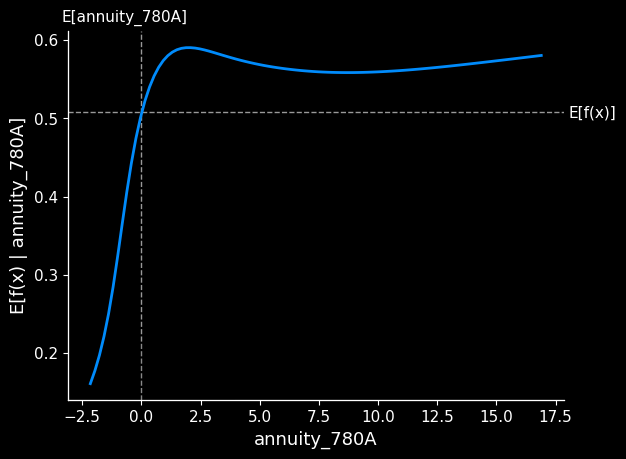

In [46]:
recon = pd.DataFrame(feature_train, columns=col_list[:-1])

shap.partial_dependence_plot(
    "annuity_780A",
    model.predict,
    recon,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

4475/4475 [==============================] - 1s 282us/step


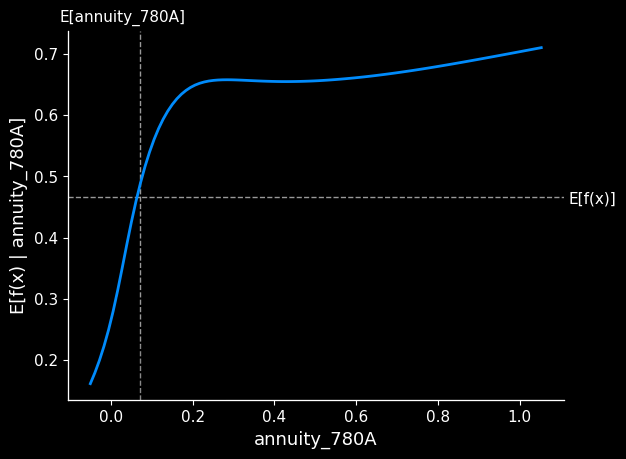

In [56]:
recon = pd.DataFrame(feature_train, columns=col_list[:-1])

shap.partial_dependence_plot(
    "annuity_780A",
    model.predict,
    recon,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [61]:
recon = pd.DataFrame(feature_train, columns=col_list[:-1])
recon.mean()

annuity_780A                  0.0000
applications30d_658L         -0.0000
applicationscnt_867L          0.0000
credamount_770A              -0.0000
disbursedcredamount_1113A    -0.0000
homephncnt_628L              -0.0000
mobilephncnt_593L             0.0000
numactivecreds_622L           0.0000
numactivecredschannel_414L    0.0000
numactiverelcontr_750L        0.0000
numcontrs3months_479L         0.0000
numrejects9m_859L             0.0000
sellerplacecnt_915L           0.0000
sellerplacescnt_216L          0.0000
totaldebt_9A                 -0.0000
annuitynextmonth_57A         -0.0000
currdebt_22A                 -0.0000
numinstls_657L                0.0000
totalsettled_863A            -0.0000
pmtnum_254L                  -0.0000
eir_270L                      0.0000
price_1097A                   0.0000
maxannuity_159A               0.0000
maxdebt4_972A                -0.0000
maxdpdlast12m_727P           -0.0000
maxdpdlast24m_143P           -0.0000
maxdpdlast3m_392P             0.0000
m

In [58]:
recon.max()

annuity_780A                 1.0000
applications30d_658L         1.0000
applicationscnt_867L         1.0000
credamount_770A              1.0000
disbursedcredamount_1113A    1.0000
homephncnt_628L              1.0000
mobilephncnt_593L            1.0000
numactivecreds_622L          1.0000
numactivecredschannel_414L   1.0000
numactiverelcontr_750L       1.0000
numcontrs3months_479L        1.0000
numrejects9m_859L            1.0000
sellerplacecnt_915L          1.0000
sellerplacescnt_216L         1.0000
totaldebt_9A                 1.0000
annuitynextmonth_57A         1.0000
currdebt_22A                 1.0000
numinstls_657L               1.0000
totalsettled_863A            1.0000
pmtnum_254L                  1.0000
eir_270L                     1.0000
price_1097A                  1.0000
maxannuity_159A              1.0000
maxdebt4_972A                1.0000
maxdpdlast12m_727P           1.0000
maxdpdlast24m_143P           1.0000
maxdpdlast3m_392P            1.0000
maxdpdlast6m_474P           

---
---
# <center> Experimentation </center>
---

In [96]:
import statistics as stat

from scipy.stats import linregress
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV




In [65]:
train_scores = []
test_scores = []
depth_list = []

# for depth in range(3,9):

# for ccp_val in range(0,10,2):

for trees in range(100, 1800, 300):

    depth=6 ### temporary

    # ccp_val = ccp_val/10000

    ccp_val = 0

    rfc = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=43, ccp_alpha=ccp_val)

    rfc.fit(feature_train, target_train)

    ##### evaluate on training dataset
    # rfc_train = rfc.predict(feature_train)
    # rfc_train_score = roc_auc_score(rfc_train, target_train)
    # train_score.append(rfc_train_score)
    train_score = cross_val_score(rfc, feature_train, target_train, scoring="roc_auc")
    train_scores.append(train_score)

    ##### evaluate on testing score
    # rfc_test_score = roc_auc_score(target_test, rfc.predict(feature_test))
    # test_score.append(rfc_test_score)

    test_score = cross_val_score(rfc, feature_test, target_test, scoring="roc_auc")
    test_scores.append(test_score)

    # depth_list.append(depth)
    # print(f"depth: {depth}")

    # depth_list.append(ccp_val)
    # print(f"alpha: {ccp_val}")

    depth_list.append(trees)
    print(f"Number of trees: {trees}")

##### Use this when use cross validation
train_scores = [np.mean(val) for val in train_scores] 
test_scores = [np.mean(val) for val in test_scores] 

fig_2 = go.Figure()

fig_2.add_trace( go.Scatter(x=depth_list, y=train_scores, name="train"))
fig_2.add_trace( go.Scatter(x=depth_list, y=test_scores, name="test"))

fig_2.show()



Number of trees: 100
Number of trees: 400
Number of trees: 700
Number of trees: 1000
Number of trees: 1300
Number of trees: 1600


In [105]:
rfc = RandomForestClassifier(max_depth=6, random_state=43, ccp_alpha=0)

# rfc.fit(feature_train, target_train)
# test_score = cross_val_score(rfc, feature_test, target_test, scoring="roc_auc")


distributions = dict(n_estimators = [val for val in range(10,1001)],
                     max_depth = [val for val in range(2,20)],
                     )

clf = RandomizedSearchCV(rfc, distributions, random_state=43)

searching = clf.fit(feature_train, target_train)

# test_score.mean()

In [106]:
searching.best_params_

{'n_estimators': 476, 'max_depth': 18}

In [107]:
# predicted = rfc.predict_proba(feature_test)
predicted = searching.predict_proba(feature_test)
predicted = [predicted[val].max() for val in range(len(predicted))]

predicted_df = pd.DataFrame(list(zip(test_case_id, predicted)), columns=["case_id", "prob"])
predicted_df = predicted_df.merge(combined_df[["case_id", "WEEK_NUM", "target"]])

predicted_df

,case_id,prob,WEEK_NUM,target
0,713806,0.6694,23,0
1,1613093,0.5745,44,1
2,1297119,0.7455,8,1
3,2597225,0.8356,28,1
4,191764,0.8158,52,1
...,...,...,...,...
61363,2545298,0.6569,7,0
61364,1791849,0.6282,59,0
61365,155731,0.6358,34,0
61366,1666122,0.6621,48,0


In [108]:
weeks = []
ginis = []

for week in range(92):

    temp = predicted_df[predicted_df["WEEK_NUM"]==week]

    ginis.append(roc_auc_score(temp["target"], temp["prob"]))
    weeks.append(week)

scoring = pd.DataFrame(list(zip(weeks, ginis)), columns=["week", "auc_roc"])
scoring["gini"] = 2*scoring["auc_roc"] - 1
scoring


,week,auc_roc,gini
0,0,0.7077,0.4154
1,1,0.6188,0.2376
2,2,0.6537,0.3074
3,3,0.6364,0.2728
4,4,0.6786,0.3572
...,...,...,...
87,87,0.5475,0.0950
88,88,0.6394,0.2788
89,89,0.5775,0.1550
90,90,0.6305,0.2610


In [109]:
fig_4 = px.scatter(scoring, x="week", y="gini", trendline="ols")
fig_4.show()

In [110]:
result = linregress(scoring["week"], scoring["gini"])
result

y_hat = result[0]*scoring["week"] + result[1]
resid = scoring["gini"] - y_hat

std_resid = stat.stdev(resid)
std_resid

0.06731339809732771

In [111]:
stability = scoring["gini"].mean() + 88*min(0,result[0]) - 0.5*std_resid
stability

0.1798680780888393

In [92]:
scoring["gini"].mean()

-0.04109519008560104

In [84]:
result[0]

1.6980148266448056e-05

In [ ]:
s

In [71]:
predicted_df = predicted_df.merge(combined_df[["case_id", "WEEK_NUM"]])


In [46]:
predicted = rfc.predict(feature_test)
predicted

array([0, 1, 1, ..., 1, 0, 1])

In [33]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [29]:
depth_list = [val for val in range(2,17)]
compare_df = pd.DataFrame(list(zip(depth_list, train_score, test_score)), columns=["depth", "train_score", "test_score"])

fig_2 = go.Figure()

fig_2.add_trace( go.Scatter(x=depth_list, y=train_score, name="train"))
fig_2.add_trace( go.Scatter(x=depth_list, y=test_score, name="test"))

fig_2.show()

In [49]:
depth_list = [val for val in range(2,17)]
compare_df = pd.DataFrame(list(zip(depth_list, train_score, test_score)), columns=["depth", "train_score", "test_score"])

fig_2 = go.Figure()

fig_2.add_trace( go.Scatter(x=depth_list, y=new1, name="train"))
fig_2.add_trace( go.Scatter(x=depth_list, y=new2, name="test"))

fig_2.show()

In [21]:
predictions = cross_val_predict(rfc, feature_train, target_train)

In [23]:
predictions.shape

(143190,)

In [44]:
person_df_1 = pd.read_csv("./csv_files/train/train_person_1.csv")
person_df_1


/var/folders/pq/7mcbx8c97t90g8y2_ns4gjkr0000gn/T/ipykernel_39845/2293800697.py:1: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.



,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,...,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,0,1986-07-01,NaN,NaN,P88_18_84,False,False,P167_100_165,P97_36_170,2017-09-15,...,P88_18_84,P167_100_165,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
1,0,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,SPOUSE,NaN,False,EM,NaN,NaN,NaN,PHONE
2,0,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,COLLEAGUE,SPOUSE,False,PE,NaN,NaN,NaN,PHONE
3,0,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,NaN,COLLEAGUE,NaN,PE,NaN,NaN,NaN,PHONE
4,1,1957-08-01,NaN,NaN,P103_93_94,False,False,P176_37_166,P97_36_170,2008-10-29,...,P103_93_94,P176_37_166,NaN,NaN,NaN,CL,NaN,True,M,PRIMARY_MOBILE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973986,2703451,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,NaN,NaN,NaN,CL,NaN,NaN,NaN,HOME_PHONE
2973987,2703452,1977-08-01,NaN,NaN,P133_44_167,False,False,P59_150_74,a55475b1,NaN,...,P19_11_176,P11_15_81,NaN,NaN,NaN,CL,NaN,False,M,PRIMARY_MOBILE
2973988,2703453,1950-02-01,NaN,NaN,P123_6_84,False,False,P46_103_143,a55475b1,NaN,...,P123_6_84,P46_103_143,NaN,NaN,NaN,CL,NaN,False,F,PRIMARY_MOBILE
2973989,2703453,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,NaN,NaN,NaN,CL,NaN,NaN,NaN,HOME_PHONE


In [45]:
person_df_1_summary = dataframe_summary(person_df_1, 15)
person_df_1_summary

,column_name,unique_count,nan_count,nan_percent,data_type,unique_entries
0,case_id,1526659,0.000,0.000,int64,>15 entries
23,num_group1,10,0.000,0.000,int64,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
25,persontype_1072L,4,"6,117.000",0.206,float64,"[1.0, 4.0, 5.0, nan]"
24,personindex_1023L,8,"642,283.000",21.597,float64,"[0.0, 1.0, 2.0, nan, 3.0, 4.0, 5.0, 6.0]"
26,persontype_792L,4,"642,283.000",21.597,float64,"[1.0, 4.0, 5.0, nan]"
21,mainoccupationinc_384A,6633,"1,447,332.000",48.666,float64,>15 entries
3,childnum_185L,12,"2,964,084.000",99.667,float64,"[nan, 0.0, 1.0, 3.0, 2.0, 4.0, 7.0, 6.0, 5.0, ..."
4,contaddr_district_15M,975,0.000,0.000,object,>15 entries
7,contaddr_zipcode_807M,3530,0.000,0.000,object,>15 entries
8,education_927M,6,0.000,0.000,object,"[P97_36_170, a55475b1, P33_146_175, P17_36_170..."


In [229]:
person_df_1_desc = describe_dataframe(person_df_1)
person_df_1_desc

,case_id,childnum_185L,mainoccupationinc_384A,num_group1,personindex_1023L,persontype_1072L,persontype_792L
count,"2,973,991.000","9,907.000","1,526,659.000","2,973,991.000","2,331,708.000","2,967,874.000","2,331,708.000"
mean,"1,055,195.612",0.616,"57,707.483",0.797,0.438,2.035,2.316
std,"724,571.385",0.966,"33,348.303",0.978,0.660,1.707,1.826
min,0.000,0.000,0.000,0.000,0.000,1.000,1.000
25%,"637,353.500",0.000,"36,000.000",0.000,0.000,1.000,1.000
50%,"890,817.000",0.000,"50,000.000",0.000,0.000,1.000,1.000
75%,"1,568,333.500",1.000,"70,000.000",1.000,1.000,4.000,5.000
max,"2,703,454.000",11.000,"200,000.000",9.000,6.000,5.000,5.000


In [242]:
columns_of_interest = ["case_id", "birth_259D", "birthdate_87D", "maritalst_703L", "familystate_447L",
                       "relationshiptoclient_415T", "relationshiptoclient_642T", "num_group1",
                       "persontype_1072L", "personindex_1023L", "persontype_792L"]
person_df_1.loc[person_df_1["case_id"].isin([31, 97, 123, 913, 0]), columns_of_interest]

,case_id,birth_259D,birthdate_87D,maritalst_703L,familystate_447L,relationshiptoclient_415T,relationshiptoclient_642T,num_group1,persontype_1072L,personindex_1023L,persontype_792L
0,0,1986-07-01,NaN,NaN,MARRIED,NaN,NaN,0,1.000,0.000,1.000
1,0,NaN,NaN,NaN,NaN,SPOUSE,NaN,1,1.000,1.000,4.000
2,0,NaN,NaN,NaN,NaN,COLLEAGUE,SPOUSE,2,4.000,2.000,5.000
3,0,NaN,NaN,NaN,NaN,NaN,COLLEAGUE,3,5.000,NaN,NaN
119,31,1972-07-01,NaN,NaN,MARRIED,NaN,NaN,0,1.000,0.000,1.000
120,31,NaN,NaN,NaN,NaN,CHILD,NaN,1,1.000,1.000,5.000
121,31,NaN,NaN,NaN,NaN,FRIEND,CHILD,2,5.000,2.000,5.000
122,31,NaN,NaN,NaN,NaN,NaN,FRIEND,3,5.000,NaN,NaN
356,97,1986-04-01,NaN,NaN,MARRIED,NaN,NaN,0,1.000,0.000,1.000
357,97,NaN,NaN,NaN,NaN,SPOUSE,NaN,1,1.000,1.000,4.000


Notes on person_df_1:
* Basically each `case_id` represents individual cases with `num_group1` == 0, that is the applicants. Other values of `num_group1` with the same `case_id` are different individuals related to the applicants.
* `relationshiptoclient_415T` and `relationshiptoclient_642T` are 2 different descriptions but not too sure what
* potential features to be use:
    * birth_259D -> get age in 2024
    * mainoccupationinc_384A
    * education_927M
    * contaddr_district_15M
    * contaddr_zipcode_807M
    * incometype_1044T
    * sex_738L
    * language1_981M


In [247]:
person_df_2 = pd.read_csv("./csv_files/train/train_person_2.csv")
person_df_2.head(5)

,case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
0,5,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
1,6,P55_110_32,CONTACT,P10_68_40,P38_92_157,P164_110_33,NaN,a55475b1,0,0,NaN
2,6,P55_110_32,PERMANENT,P10_68_40,a55475b1,a55475b1,NaN,a55475b1,0,1,NaN
3,6,P204_92_178,CONTACT,P65_136_169,P38_92_157,P164_110_33,NaN,a55475b1,1,0,OTHER_RELATIVE
4,6,P191_109_75,CONTACT,P10_68_40,P7_147_157,a55475b1,NaN,a55475b1,1,1,OTHER_RELATIVE


In [248]:
person_df_2_summary = dataframe_summary(person_df_2, 15)
person_df_2_summary

,column_name,unique_count,nan_count,nan_percent,data_type,unique_entries
0,case_id,1435105,0.000,0.000,int64,>15 entries
8,num_group1,5,0.000,0.000,int64,"[0, 1, 2, 3, 4]"
9,num_group2,32,0.000,0.000,int64,>15 entries
1,addres_district_368M,508,0.000,0.000,object,>15 entries
3,addres_zip_823M,2027,0.000,0.000,object,>15 entries
4,conts_role_79M,11,0.000,0.000,object,"[a55475b1, P38_92_157, P7_147_157, P177_137_98..."
5,empls_economicalst_849M,10,0.000,0.000,object,"[a55475b1, P164_110_33, P22_131_138, P28_32_17..."
7,empls_employer_name_740M,7153,0.000,0.000,object,>15 entries
2,addres_role_871L,9,"1,575,736.000",95.882,object,"[nan, CONTACT, PERMANENT, TEMPORARY, REGISTERE..."
10,relatedpersons_role_762T,11,"1,614,684.000",98.252,object,"[nan, OTHER_RELATIVE, PARENT, COLLEAGUE, FRIEN..."


Notes on person_df_2:
* There are some intersection between `case_id` in person_df_1 and person_df_2. However, some `case_id` may only exist in either one of the tables
* Potential features to be used:
    * addres_district_368M
    * addres_zip_823M	
    * conts_role_79M

In [29]:
deposit_df = pd.read_csv("./csv_files/train/train_deposit_1.csv")
deposit_df

,case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
0,225,0.00000,NaN,0,2016-08-16
1,331,260.37400,2018-03-18,0,2015-03-19
2,358,0.00000,NaN,0,2014-09-02
3,390,211748.53000,2017-07-22,0,2014-07-23
4,390,223.68001,NaN,2,2016-06-08
...,...,...,...,...,...
145081,2703430,22918.00600,NaN,8,2016-11-26
145082,2703430,0.00000,NaN,2,2014-02-14
145083,2703439,219.98401,NaN,0,2016-11-25
145084,2703453,44916.64500,2018-05-28,1,2015-05-29


In [38]:
deposit_summary = dataframe_summary(deposit_df, 15)
deposit_summary

,column_name,unique_count,nan_count,nan_percent,data_type,unique_entries
0,case_id,105111,0.0,0.00000,int64,>15 entries
3,num_group1,65,0.0,0.00000,int64,>15 entries
1,amount_416A,40724,0.0,0.00000,float64,>15 entries
4,openingdate_313D,1579,0.0,0.00000,object,>15 entries
2,contractenddate_991D,1525,79682.0,54.92053,object,>15 entries
5,this_df,145086,NaN,NaN,NaN,NaN


In [39]:
deposit_desc = describe_dataframe(deposit_df)
deposit_desc

,case_id,amount_416A,num_group1
count,"145,086.000","145,086.000","145,086.000"
mean,"1,466,214.050","8,422.304",0.523
std,"886,528.959","86,232.120",1.621
min,225.000,"-40,000.000",0.000
25%,"660,041.000",0.000,0.000
50%,"1,556,939.000",223.658,0.000
75%,"2,530,539.000",478.340,1.000
max,"2,703,453.000","12,213,286.000",64.000


In [30]:
deposit_df.groupby(["case_id", "num_group1"]).count()

amount_416A  contractenddate_991D  openingdate_313D
case_id num_group1                                                     
225     0                     1                     0                 1
331     0                     1                     1                 1
358     0                     1                     0                 1
390     0                     1                     1                 1
        1                     1                     1                 1
...                         ...                   ...               ...
2703430 7                     1                     0                 1
        8                     1                     0                 1
2703439 0                     1                     0                 1
2703453 0                     1                     0                 1
        1                     1                     1                 1

[145086 rows x 3 columns]

In [34]:
deposit_df[deposit_df["case_id"]==2703430].sort_values("openingdate_313D")

,case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
145076,2703430,0.000,NaN,1,2013-09-02
145082,2703430,0.000,NaN,2,2014-02-14
145079,2703430,0.000,NaN,0,2015-02-13
145075,2703430,0.000,NaN,4,2015-03-19
145078,2703430,0.000,NaN,3,2015-03-19
145080,2703430,0.000,NaN,5,2015-08-25
145074,2703430,0.000,NaN,6,2015-12-11
145077,2703430,0.000,NaN,7,2016-02-25
145081,2703430,22918.006,NaN,8,2016-11-26


In [32]:
base_df[base_df["case_id"]==2703430]

,case_id,date_decision,MONTH,WEEK_NUM,target
1526635,2703430,2020-10-05,202010,91,0


In [42]:
prev_appl_1_df = pd.read_csv("./csv_files/train/train_applprev_1_0.csv")
prev_appl_1_df


/var/folders/pq/7mcbx8c97t90g8y2_ns4gjkr0000gn/T/ipykernel_39845/739880207.py:1: DtypeWarning:

Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.



,case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,...,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
0,2,0.000,640.200,NaN,NaN,a55475b1,0.000,2013-04-03,NaN,0.000,...,0,NaN,24.000,a55475b1,a55475b1,a55475b1,a55475b1,NaN,D,24.000
1,2,0.000,"1,682.400",NaN,NaN,a55475b1,0.000,2013-04-03,NaN,0.000,...,1,NaN,12.000,a55475b1,a55475b1,a55475b1,a55475b1,NaN,D,12.000
2,3,0.000,"6,140.000",NaN,NaN,P94_109_143,NaN,2019-01-07,NaN,0.000,...,0,NaN,12.000,a55475b1,a55475b1,P94_109_143,a55475b1,NaN,D,12.000
3,4,0.000,"2,556.600",NaN,NaN,P24_27_36,NaN,2019-01-08,NaN,0.000,...,0,NaN,24.000,a55475b1,a55475b1,a55475b1,a55475b1,NaN,T,24.000
4,5,0.000,NaN,NaN,NaN,P85_114_140,NaN,2019-01-16,NaN,NaN,...,0,NaN,NaN,a55475b1,a55475b1,a55475b1,a55475b1,NaN,T,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887679,2651092,0.000,0.000,NaN,NaN,P94_109_143,NaN,2018-05-04,NaN,"100,000.000",...,3,NaN,NaN,P46_145_78,a55475b1,P99_56_166,P94_109_143,NaN,D,NaN
3887680,2651092,0.000,"4,366.000",2017-11-09,NaN,a55475b1,NaN,2017-11-09,NaN,0.000,...,4,0.000,5.000,P60_146_156,a55475b1,a55475b1,a55475b1,NaN,K,5.000
3887681,2651092,0.000,"2,632.200",2015-12-11,1.000,a55475b1,1.000,2015-12-11,NaN,0.000,...,5,0.000,14.000,P46_145_78,a55475b1,a55475b1,a55475b1,NaN,K,14.000
3887682,2651092,0.000,NaN,2014-02-15,"60,000.000",a55475b1,1.000,2014-02-15,NaN,"53,300.000",...,6,0.000,NaN,P46_145_78,a55475b1,a55475b1,a55475b1,"680,531,000.000",K,NaN


In [43]:
prev_appl_1_summary = dataframe_summary(prev_appl_1_df, 15)
prev_appl_1_summary



,column_name,unique_count,nan_count,nan_percent,data_type,unique_entries
0,case_id,782997,0.000,0.000,int64,>15 entries
31,num_group1,20,0.000,0.000,int64,>15 entries
1,actualdpd_943P,102,"2,234.000",0.057,float64,>15 entries
29,mainoccupationinc_437A,21958,"36,612.000",0.942,float64,>15 entries
9,credacc_credlmt_575A,37850,"119,070.000",3.063,float64,>15 entries
14,credamount_590A,201794,"123,329.000",3.172,float64,>15 entries
19,downpmt_134A,18721,"123,329.000",3.172,float64,>15 entries
2,annuity_853A,80310,"155,851.000",4.009,float64,>15 entries
33,pmtnum_8L,58,"312,833.000",8.047,float64,>15 entries
40,tenor_203L,58,"312,833.000",8.047,float64,>15 entries


In [56]:
static_summary[(static_summary["nan_percent"]<10) & (static_summary["data_type"]==object)]

,column_name,unique_count,nan_count,nan_percent,data_type,unique_entries
69,lastapprcommoditycat_1041M,45,0.000,0.000,object,>15 entries
70,lastapprcommoditytypec_5251766M,214,0.000,0.000,object,>15 entries
73,lastcancelreason_561M,74,0.000,0.000,object,>15 entries
78,lastrejectcommoditycat_161M,45,0.000,0.000,object,>15 entries
79,lastrejectcommodtypec_5251769M,187,0.000,0.000,object,>15 entries
82,lastrejectreason_759M,18,0.000,0.000,object,>15 entries
83,lastrejectreasonclient_4145040M,14,0.000,0.000,object,"[a55475b1, P94_109_143, P129_162_80, P30_86_84..."
156,previouscontdistrict_112M,223,0.000,0.000,object,>15 entries
42,credtype_322L,4,1.000,0.000,object,"[CAL, REL, COL, nan]"
61,inittransactioncode_186L,4,1.000,0.000,object,"[CASH, NDF, POS, nan]"


In [51]:
static_summary.loc[144, "data_type"]

dtype('O')

In [35]:
debit_df = pd.read_csv("./csv_files/train/train_debitcard_1.csv")
debit_df


,case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D
0,225,NaN,NaN,NaN,0,2016-08-16
1,331,NaN,NaN,NaN,0,2015-03-19
2,358,NaN,NaN,NaN,0,2014-09-02
3,390,NaN,NaN,NaN,0,2014-07-23
4,390,NaN,NaN,NaN,2,2016-06-08
...,...,...,...,...,...,...
157297,2703430,NaN,NaN,NaN,8,2016-11-26
157298,2703430,NaN,NaN,NaN,2,2014-02-14
157299,2703439,NaN,NaN,NaN,0,2016-11-25
157300,2703453,NaN,NaN,NaN,1,2015-05-29


In [41]:
debit_summary = dataframe_summary(debit_df, 15)
debit_summary

,column_name,unique_count,nan_count,nan_percent,data_type,unique_entries
0,case_id,111772,0.000,0.000,int64,>15 entries
4,num_group1,66,0.000,0.000,int64,>15 entries
1,last180dayaveragebalance_704A,2496,"145,086.000",92.234,float64,>15 entries
2,last180dayturnover_1134A,2582,"146,221.000",92.956,float64,>15 entries
3,last30dayturnover_651A,483,"146,221.000",92.956,float64,>15 entries
5,openingdate_857D,1579,"12,711.000",8.081,object,>15 entries
6,this_df,157302,NaN,NaN,NaN,NaN


In [164]:
temp = base_df.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
temp
temp

,column_name,data_type
0,case_id,int64
1,date_decision,object
2,MONTH,int64
3,WEEK_NUM,int64
4,target,int64


In [141]:
sub_credit_df.groupby(["sex_738L", "target"]).count()

incometype_1044T  mainoccupationinc_384A  \
sex_738L target                                             
F        0                 927562                  927562   
         1                  25214                   25214   
M        0                 551103                  551103   
         1                  22780                   22780   

                 registaddr_zipcode_184M  birth_259D  applicant_bday  \
sex_738L target                                                        
F        0                        927562      927562          927562   
         1                         25214       25214           25214   
M        0                        551103      551103          551103   
         1                         22780       22780           22780   

                 age_in_2024  
sex_738L target               
F        0            927562  
         1             25214  
M        0            551103  
         1             22780

In [125]:
credit_df.dtypes

case_id                        int64
date_decision                 object
MONTH                          int64
WEEK_NUM                       int64
target                         int64
birth_259D                    object
contaddr_district_15M         object
contaddr_zipcode_807M         object
education_927M                object
empladdr_district_926M        object
empladdr_zipcode_114M         object
incometype_1044T              object
language1_981M                object
mainoccupationinc_384A       float64
num_group1                     int64
personindex_1023L            float64
persontype_1072L             float64
persontype_792L              float64
registaddr_district_1083M     object
registaddr_zipcode_184M       object
role_1084L                    object
safeguarantyflag_411L         object
sex_738L                      object
type_25L                      object
dtype: object

In [86]:
person_df_1[person_df_1["case_id"]==147982][["case_id", "num_group1", "personindex_1023L", "persontype_1072L",
                                             "", "persontype_792L", "role_1084L", "role_993L"]]

,case_id,num_group1,personindex_1023L,persontype_1072L,persontype_792L,role_1084L,role_993L
331801,147982,0,0.0,1.0,1.0,CL,NaN
331802,147982,1,1.0,1.0,5.0,EM,NaN
331803,147982,2,2.0,1.0,5.0,EM,NaN
331804,147982,3,3.0,1.0,5.0,CL,NaN
331805,147982,4,NaN,5.0,NaN,PE,NaN
331806,147982,5,NaN,5.0,NaN,PE,NaN
331807,147982,6,NaN,5.0,NaN,PE,NaN
331808,147982,7,NaN,5.0,NaN,PE,NaN
331809,147982,8,NaN,5.0,NaN,PE,NaN
331810,147982,9,NaN,5.0,NaN,PE,NaN


In [88]:
person_df_1[person_df_1["case_id"]==0]

,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,...,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,0,1986-07-01,NaN,NaN,P88_18_84,False,False,P167_100_165,P97_36_170,2017-09-15,...,P88_18_84,P167_100_165,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
1,0,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,SPOUSE,NaN,False,EM,NaN,NaN,NaN,PHONE
2,0,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,COLLEAGUE,SPOUSE,False,PE,NaN,NaN,NaN,PHONE
3,0,NaN,NaN,NaN,a55475b1,NaN,NaN,a55475b1,a55475b1,NaN,...,a55475b1,a55475b1,NaN,COLLEAGUE,NaN,PE,NaN,NaN,NaN,PHONE


In [92]:
person_df_1[person_df_1["case_id"]==0][["case_id", "num_group1", "personindex_1023L", "persontype_1072L", "maritalst_703L",
                                        "relationshiptoclient_415T", "relationshiptoclient_642T", "persontype_792L", 
                                        "role_1084L", "role_993L"]]

,case_id,num_group1,personindex_1023L,persontype_1072L,maritalst_703L,relationshiptoclient_415T,relationshiptoclient_642T,persontype_792L,role_1084L,role_993L
0,0,0,0.0,1.0,NaN,NaN,NaN,1.0,CL,NaN
1,0,1,1.0,1.0,NaN,SPOUSE,NaN,4.0,EM,NaN
2,0,2,2.0,4.0,NaN,COLLEAGUE,SPOUSE,5.0,PE,NaN
3,0,3,NaN,5.0,NaN,NaN,COLLEAGUE,NaN,PE,NaN


In [95]:
temp = person_df_1[person_df_1["num_group1"]==0]

In [96]:
temp

,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,...,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,0,1986-07-01,NaN,NaN,P88_18_84,False,False,P167_100_165,P97_36_170,2017-09-15,...,P88_18_84,P167_100_165,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
4,1,1957-08-01,NaN,NaN,P103_93_94,False,False,P176_37_166,P97_36_170,2008-10-29,...,P103_93_94,P176_37_166,NaN,NaN,NaN,CL,NaN,True,M,PRIMARY_MOBILE
9,2,1974-12-01,NaN,NaN,P91_125_184,False,False,P161_5_97,P97_36_170,2010-02-15,...,P91_125_184,P161_5_97,NaN,NaN,NaN,EM,NaN,True,F,PRIMARY_MOBILE
14,3,1993-08-01,NaN,NaN,P155_139_77,False,False,P161_14_174,P33_146_175,2018-05-15,...,P155_139_77,P161_14_174,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
17,4,1994-01-01,NaN,NaN,P194_82_174,False,False,P8_88_79,P33_146_175,2014-12-15,...,P194_82_174,P8_88_79,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973984,2703450,1960-01-01,NaN,NaN,P123_39_170,False,False,P40_33_175,a55475b1,NaN,...,P123_39_170,P40_33_175,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
2973985,2703451,1950-11-01,NaN,NaN,P162_18_172,False,False,P80_161_153,a55475b1,NaN,...,P162_18_172,P80_161_153,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE
2973987,2703452,1977-08-01,NaN,NaN,P133_44_167,False,False,P59_150_74,a55475b1,NaN,...,P19_11_176,P11_15_81,NaN,NaN,NaN,CL,NaN,False,M,PRIMARY_MOBILE
2973988,2703453,1950-02-01,NaN,NaN,P123_6_84,False,False,P46_103_143,a55475b1,NaN,...,P123_6_84,P46_103_143,NaN,NaN,NaN,CL,NaN,False,F,PRIMARY_MOBILE


In [97]:
len(set(temp["case_id"].to_list()))

1526659

In [98]:
temp[temp["case_id"]==5]

,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,...,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
21,5,1979-10-01,NaN,NaN,P54_133_26,False,False,P66_157_171,P97_36_170,2016-01-15,...,P54_133_26,P66_157_171,NaN,NaN,NaN,CL,NaN,True,F,PRIMARY_MOBILE


In [33]:
person_df_2 = pd.read_csv("./csv_files/train/train_person_2.csv")
person_df_2

,case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
0,5,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
1,6,P55_110_32,CONTACT,P10_68_40,P38_92_157,P164_110_33,NaN,a55475b1,0,0,NaN
2,6,P55_110_32,PERMANENT,P10_68_40,a55475b1,a55475b1,NaN,a55475b1,0,1,NaN
3,6,P204_92_178,CONTACT,P65_136_169,P38_92_157,P164_110_33,NaN,a55475b1,1,0,OTHER_RELATIVE
4,6,P191_109_75,CONTACT,P10_68_40,P7_147_157,a55475b1,NaN,a55475b1,1,1,OTHER_RELATIVE
...,...,...,...,...,...,...,...,...,...,...,...
1643405,2703450,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
1643406,2703451,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
1643407,2703452,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
1643408,2703453,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN


------


In [73]:
##### Code used to compile metadata

import os, warnings

warnings.filterwarnings("ignore")

path = "./csv_files/train/"
dir_list = os.listdir(path)

filename_dict = {}

for filename in dir_list:

    temp_df = pd.read_csv("./csv_files/train/" + filename)

    col_names = temp_df.columns.to_list()

    filename_dict[filename] = col_names

    print(filename)

files = []
columns = []
depth_list = []

for val in filename_dict.keys():

    files = files + [val]*len(filename_dict[val])
    columns = columns + filename_dict[val]
    print(val)



for val in files:

    temp = val[:-4].split("_")
    temp = [val for val in temp if val.isdigit()]

    if len(temp)>0:
        depth_list.append(int(temp[0]))
    else:
        depth_list.append(np.nan)


metadata = pd.DataFrame(list(zip(files, columns, depth_list)), columns=["filename", "col_names", "data_depth"])
metadata

train_static_0_1.csv
train_static_0_0.csv
train_static_cb_0.csv
train_other_1.csv
train_debitcard_1.csv
train_person_1.csv
train_person_2.csv
train_applprev_2.csv
train_credit_bureau_a_2_8.csv
train_credit_bureau_a_2_9.csv
train_credit_bureau_a_2_4.csv
train_credit_bureau_a_2_5.csv
train_tax_registry_b_1.csv
train_credit_bureau_a_2_10.csv
train_credit_bureau_a_2_7.csv
train_credit_bureau_a_2_6.csv
train_credit_bureau_a_2_2.csv
train_credit_bureau_a_2_3.csv
train_applprev_1_1.csv
train_deposit_1.csv
train_credit_bureau_a_2_1.csv
train_credit_bureau_a_2_0.csv
train_applprev_1_0.csv
train_tax_registry_a_1.csv
train_credit_bureau_b_1.csv
train_base.csv
train_credit_bureau_b_2.csv
train_tax_registry_c_1.csv
train_credit_bureau_a_1_3.csv
train_credit_bureau_a_1_2.csv
train_credit_bureau_a_1_0.csv
train_credit_bureau_a_1_1.csv
